In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, WeibullFitter, CoxPHFitter
from lifelines.plotting import qq_plot

from mypackage import dir

smote = SMOTE(random_state=42)
iso_forest = IsolationForest(contamination=0.1, random_state=42)

In [25]:
# Environment variables
project = 'british'
data = dir.make_dir(project) 
raw = data('raw')
processed = data('processed')
outputs = data('outputs')

In [ ]:
# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

def interpret_cox_model(cph):
    for col in cph.params_.index:
        if col != 'Intercept':  # El intercepto no es relevante en Cox PH
            exp_coef = np.exp(cph.params_.loc[col])
            if exp_coef - 1 > 0:
                print(f'When {col} increases by one unit, the hazard (risk) increases by a factor of: {round(100 * (exp_coef - 1), 2)}%')
            else:
                print(f'When {col} increases by one unit, the hazard (risk) decreases by a factor of: {round(100 * (1 - exp_coef), 2)}%')


In [ ]:
# Identificar columnas
numeric_features = ['tenure', 'total_amount', 'inversion_inicial', 'primera_inversion', 'numero_inversiones',]
categorical_features = ['session', 'territorio', 'bienes_raíces_legal_y_hospitalidad', 'comercio_y_negocios',
                        'educación_y_empleo', 'eventos_y_viajes', 'finanzas_y_seguros',  
                        'medios_y_entretenimiento', 'otro', 'redes_sociales_y_comunicación', 'salud_y_bienestar',
                        'tecnología_y_software',]

In [ ]:
df = cargar_datos('dataset')
df['status'] = df['status'].astype('int')
df = df.loc[:,['tenure', 'total_amount', 'numero_inversiones', 
               'session', 'tecnología_y_software', 'country',
               'status']]

# Eliminar atipicos
df['anomaly'] = iso_forest.fit_predict(df)
df = df[df['anomaly'] == 1].drop(columns='anomaly')

df.head()

Loaded table: dataset


,tenure,total_amount,numero_inversiones,session,tecnología_y_software,country,status
646,6,15000,1,0,0.0,14,0
666,6,3000000,1,1,0.0,12,0
217,5,0,0,0,0.0,12,0
635,7,0,0,0,0.0,14,0
160,7,500000,1,1,0.0,14,0


In [ ]:
X = df.drop(['status'], axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

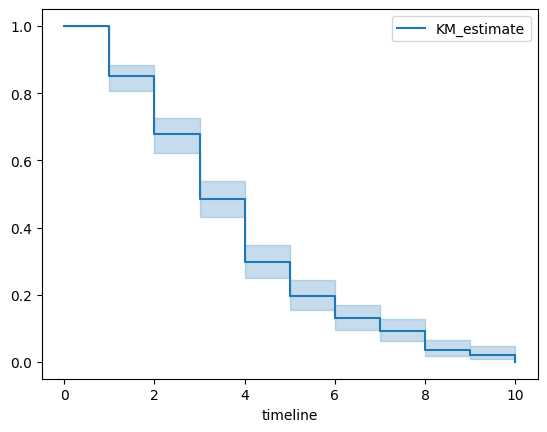

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['tenure'], event_observed=df['status'])
kmf.plot();

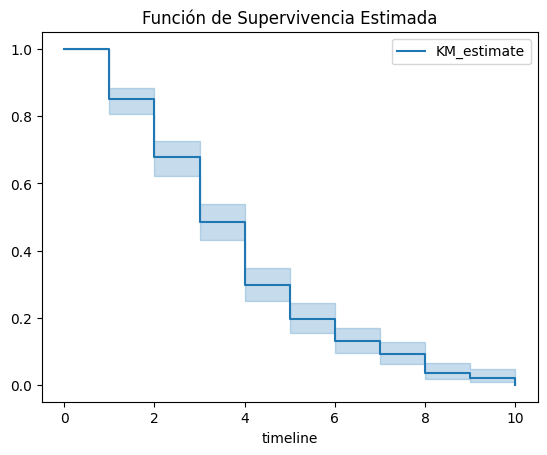

In [34]:
kmf.plot_survival_function()
plt.title('Función de Supervivencia Estimada')
plt.show()

In [35]:
mediana = kmf.median_survival_time_
print(f"Mediana de Supervivencia: {mediana}")

Mediana de Supervivencia: 3.0


In [36]:
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.805365,0.884394
2.0,0.622784,0.725392
3.0,0.430009,0.539414
4.0,0.248552,0.348540
5.0,0.155819,0.242860
6.0,0.096288,0.170244
7.0,0.063713,0.128386
8.0,0.018412,0.063801
9.0,0.007623,0.045980


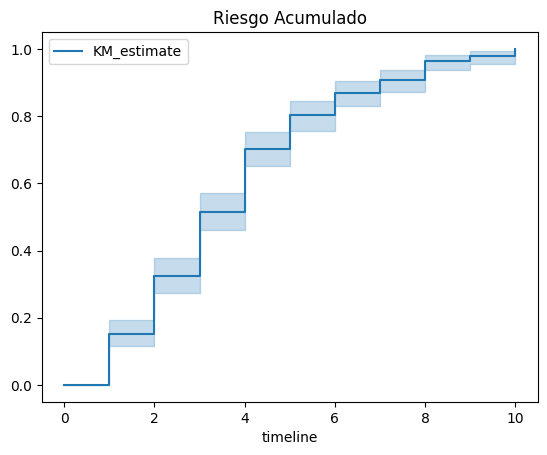

In [37]:
kmf.plot_cumulative_density()
plt.title('Riesgo Acumulado')
plt.show()

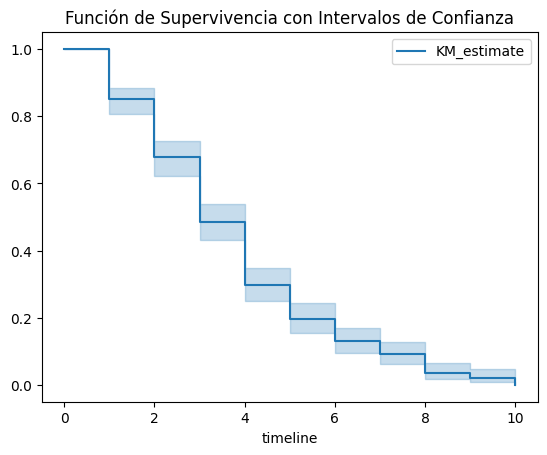

In [38]:
kmf.plot_survival_function(ci_show=True)
plt.title('Función de Supervivencia con Intervalos de Confianza')
plt.show()

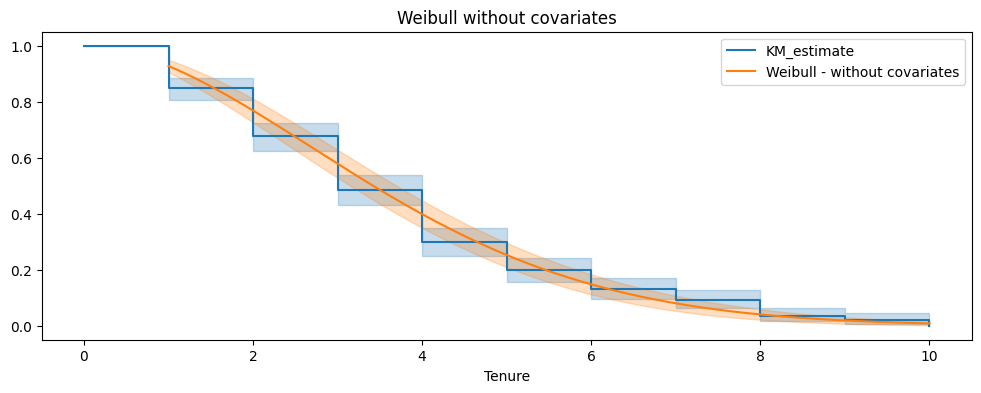

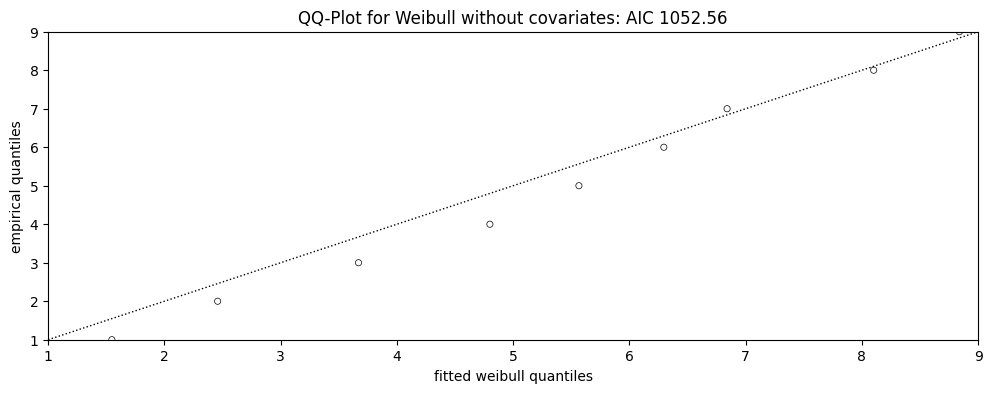

In [ ]:
wb = WeibullFitter(label="Weibull - without covariates")
T = X_train['tenure'] # durations
E = y_train # event

wb.fit(T, E)

# Graficar WeibullFitter
kmf.plot(figsize = (12,4))
wb.plot_survival_function()
plt.title(f'Weibull without covariates')
plt.xlabel('Tenure')
plt.show()

# QQ-Plot
plt.figure(figsize = (12,4))
qq_plot(wb)
plt.title(f'QQ-Plot for Weibull without covariates: AIC {round(wb.AIC_,2)}')
plt.show()

<lifelines.CoxPHFitter: fitted with 255 total observations, 6 right-censored observations>
             duration col = 'tenure'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 255
number of events observed = 249
   partial log-likelihood = -1137.56
         time fit was run = 2025-03-19 15:07:24 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
total_amount            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
numero_inversiones     -0.05       0.95       0.06            -0.17             0.08                 0.84                 1.08
session                -0.17       0.84       0.13            -0.43             0.08                 0.65                 1.09
tecnología_y_software  -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.28
country                -0.13       0.88       0.04            -0.21            -0.05                 0.81                 0.95

                        cmp to     z      p   -log2(p)
covariate                                             
total_amount              0.00  0.34   0.74       0.44
numero_inversiones        0.00 -0.75   0.45       1.14
session                   0.00 -1.33   0.18       2.44
tecnología_y_software     0.00 -0.08   0.93       0.10
country                   0.00 -3.19 <0.005       9.48
---
Concordance = 0.56
Partial AIC = 2285.12
log-likelihood ratio test = 10.00 on 5 df
-log2(p) of ll-ratio test = 3.74

None

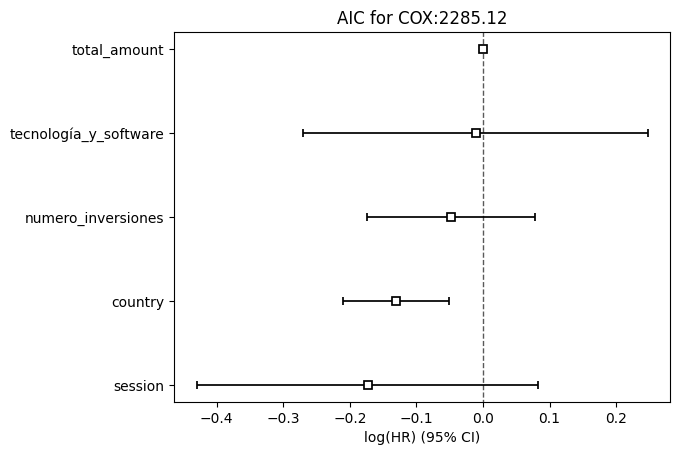

In [ ]:
# Instance of CoxPHFitter 
cph = CoxPHFitter()

X_train.loc[:, "Event"] = y_train.values

cph.fit(df = X_train, duration_col = 'tenure', event_col = 'Event')
display(cph.print_summary())

cph.plot()
plt.title(f'AIC for COX:{round(cph.AIC_partial_,2)}')
plt.show()

The mode of the country variable is: 12


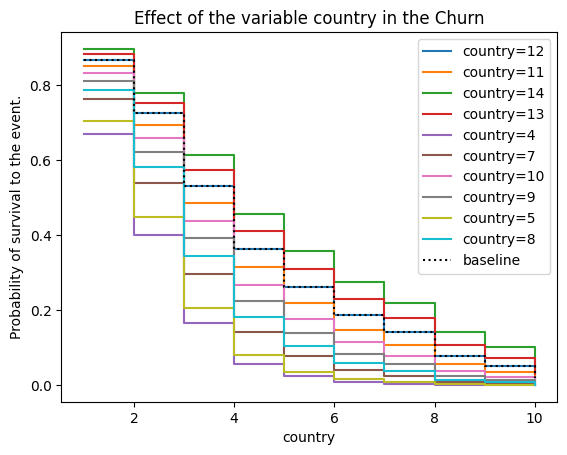

In [ ]:
# Visual model contribution. As a baseline, the model take the mode (if feature categorical)
# or median (if feature numerical) and observe the effect of the other values of that feature on it.
print(f'The mode of the country variable is: {X_train.country.mode()[0]}')
cph.plot_partial_effects_on_outcome(covariates = 'country',
                                    values = X_train.country.unique().tolist())
plt.title('Effect of the variable country in the Churn')
plt.xlabel('country')
plt.ylabel('Probability of survival to the event.')
plt.show()

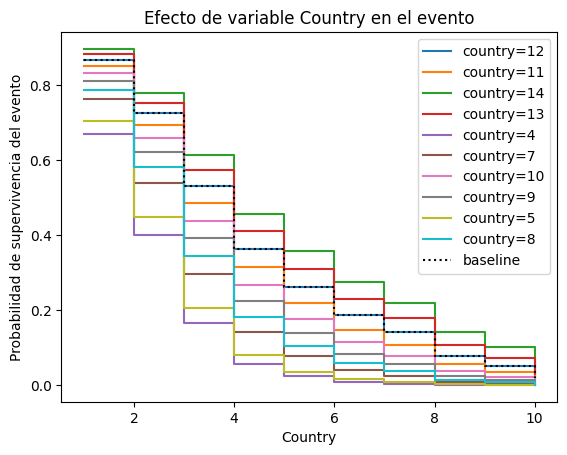

In [43]:
cph.plot_partial_effects_on_outcome(covariates = 'country',
                                    values = X_train.country.unique().tolist())
plt.title('Efecto de variable Country en el evento')
plt.xlabel('Country')
plt.ylabel('Probabilidad de supervivencia del evento')
plt.show()

The mode of the country variable is: 1


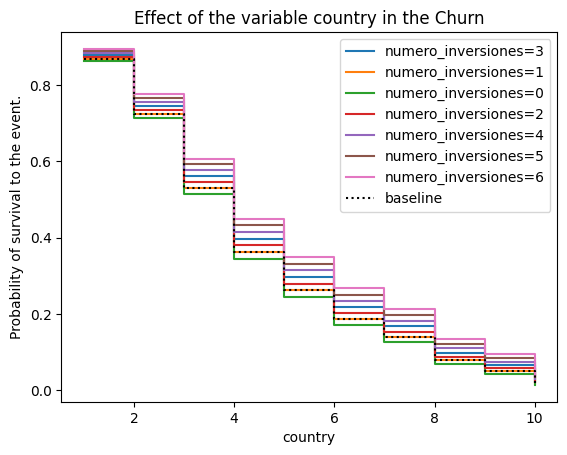

In [22]:
# Visual model contribution. As a baseline, the model take the mode (if feature categorical)
# or median (if feature numerical) and observe the effect of the other values of that feature on it.
print(f'The mode of the country variable is: {X_train.numero_inversiones.mode()[0]}')
cph.plot_partial_effects_on_outcome(covariates = 'numero_inversiones',
                                       values = X_train.numero_inversiones.unique().tolist())
plt.title('Effect of the variable country in the Churn')
plt.xlabel('country')
plt.ylabel('Probability of survival to the event.')
plt.show()

In [ ]:
interpret_cox_model(cph)

When total_amount increases by one unit, the hazard (risk) increases by a factor of: 0.0%
When numero_inversiones increases by one unit, the hazard (risk) decreases by a factor of: 4.7%
When session increases by one unit, the hazard (risk) decreases by a factor of: 15.91%
When tecnología_y_software increases by one unit, the hazard (risk) decreases by a factor of: 1.11%
When country increases by one unit, the hazard (risk) decreases by a factor of: 12.23%
